In [12]:
import pickle
import os
import time
import string
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
tf.__version__

'1.8.0'

In [3]:
#DATAPATH
DATAPATH = "/Users/srikanth_m07/Documents/ml_dataset/vision/notMNIST/"

In [4]:
#load the dataset
pickle_file = 'notMNIST.pickle'
fileObject = open(os.path.join(DATAPATH, pickle_file),'rb')
data = pickle.load(fileObject)

In [5]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(data['train_dataset'], data['train_labels'])
test_dataset, test_labels = randomize(data['test_dataset'], data['test_labels'])
valid_dataset, valid_labels = randomize(data['valid_dataset'], data['valid_labels'])

In [6]:
train_dataset.shape, train_labels.shape, test_dataset.shape, test_labels.shape, valid_dataset.shape, valid_labels.shape

((200000, 28, 28),
 (200000,),
 (10000, 28, 28),
 (10000,),
 (10000, 28, 28),
 (10000,))

In [7]:
def show_label_image(idx):
    print('Labels :-', string.ascii_uppercase[train_labels[idx]])
    return plt.imshow(train_dataset[idx])

Labels :- C


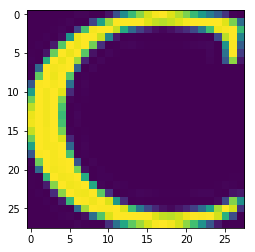

In [13]:
show_label_image(0)

Labels :- F


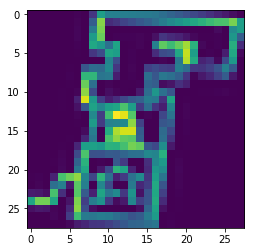

In [14]:
show_label_image(1)

#### Reformat data into Tensorflow friendly shape
. convolutions need the image data formatted as a cube (width x hight x channels) <br>
. labels as float 1-hot encodings

In [51]:
#define hyperparameters
learning_rate = 0.01
#learning_rate = 0.4
regularization = 0.12
dropout_rate = 0.5
image_size = 28
batch_size = 128
n_epochs = 15001
num_labels = 10
num_channels = 1 #grayscale

In [27]:
def reformat(dataset, labels):
    #print(dataset.shape)
    dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
    #print(dataset.shape)
    labels = (np.arange(num_labels) == labels[:, None]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)

print('Training set ', train_dataset.shape, train_labels.shape)
print('Validation set ', valid_dataset.shape, valid_labels.shape)
print('Testing set ', test_dataset.shape, test_labels.shape)

Training set  (200000, 28, 28, 1) (200000, 10)
Validation set  (10000, 28, 28, 1) (10000, 10)
Testing set  (10000, 28, 28, 1) (10000, 10)


In [49]:
#define accuracy
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))/predictions.shape[0])

In [30]:
def get_relu(logits):
    relu = tf.nn.relu(logits)
    if train:
        return tf.nn.dropout(relu, dropout_rate)
    else:
        return relu

In [35]:
#CNN core parameters
patch_size = 13
depth = 16
pooling_size = 2
stride_movement = [1, 2, 2, 1]

In [31]:
num_hidden = 64
def get_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1))
def get_biases(shape):
    return tf.Variable(tf.constant(1.0, shape=[shape[-1]]))
def get_weights_biases(shape):
    weights = get_weights(shape)
    biases = get_biases(shape)
    return weights, biases

In [45]:
graph = tf.Graph()

with graph.as_default():

  # Input data.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
    layer1_weights = get_weights([patch_size, patch_size, num_channels, depth])
    layer1_biases = tf.Variable(tf.zeros([depth]))

    layer3_weights, layer3_biases = get_weights_biases([4, 4, depth, depth*2])
    layer5_weights, layer5_biases = get_weights_biases([2, 2, depth*2, num_hidden])
    layer6_weights, layer6_biases = get_weights_biases([num_hidden, num_hidden])
    layer7_weights, layer7_biases = get_weights_biases([num_hidden, num_hidden])
    layer8_weights, layer8_biases = get_weights_biases([num_hidden, num_labels])
  
  # Model.
    def model(data, train=False):
        
        conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='VALID')
        hidden = tf.nn.relu(conv + layer1_biases)

        pool = tf.nn.max_pool(hidden, [1, pooling_size, pooling_size, 1], stride_movement, padding='SAME')
        hidden = tf.nn.relu(pool)

        conv = tf.nn.conv2d(hidden, layer3_weights, stride_movement, padding='SAME')
        hidden = tf.nn.relu(conv + layer3_biases)

        pool = tf.nn.max_pool(hidden, [1, pooling_size, pooling_size, 1], stride_movement, padding='SAME')
        hidden = tf.nn.relu(pool)

        conv = tf.nn.conv2d(hidden, layer5_weights, [1, 1, 1, 1], padding='VALID')
        hidden = tf.nn.relu(conv + layer5_biases)

        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])

        def get_relu(logits):
            relu = tf.nn.relu(logits)
            if train:
                return tf.nn.dropout(relu, dropout_rate)
            else:
                return relu

        fully_connected = tf.matmul(reshape, layer6_weights) + layer6_biases
        hidden = get_relu(fully_connected)

        fully_connected = tf.matmul(hidden, layer7_weights) + layer7_biases
        hidden = get_relu(fully_connected)

        classifier = tf.matmul(hidden, layer8_weights) + layer8_biases

        return classifier
  
  # Training computation.
    logits = model(tf_train_dataset, train=True)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=tf_train_labels))
    
    l2_loss = loss + (regularization * tf.nn.l2_loss(layer8_weights))
    global_step = tf.Variable(0)
    lr = tf.train.exponential_decay(learning_rate, global_step, 300, 0.99 )
  
  # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(lr).minimize(l2_loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [52]:
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(n_epochs):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 1000 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.371017
Minibatch accuracy: 7.0%
Validation accuracy: 6.6%
Minibatch loss at step 1000: 1.511997
Minibatch accuracy: 48.4%
Validation accuracy: 58.1%
Minibatch loss at step 2000: 1.303013
Minibatch accuracy: 60.2%
Validation accuracy: 66.2%
Minibatch loss at step 3000: 0.934684
Minibatch accuracy: 67.2%
Validation accuracy: 74.3%
Minibatch loss at step 4000: 0.987666
Minibatch accuracy: 69.5%
Validation accuracy: 78.6%
Minibatch loss at step 5000: 0.712327
Minibatch accuracy: 79.7%
Validation accuracy: 80.2%
Minibatch loss at step 6000: 0.769570
Minibatch accuracy: 74.2%
Validation accuracy: 81.0%
Minibatch loss at step 7000: 0.671988
Minibatch accuracy: 83.6%
Validation accuracy: 81.4%
Minibatch loss at step 8000: 0.703524
Minibatch accuracy: 78.9%
Validation accuracy: 82.0%
Minibatch loss at step 9000: 0.721824
Minibatch accuracy: 73.4%
Validation accuracy: 82.5%
Minibatch loss at step 10000: 0.649094
Minibatch accuracy: 78.9%
Validation accurac